In [1]:
from juliacall import Main as jl
jl.seval("using Korg")
Korg = jl.Korg

In [2]:
import matplotlib.pyplot as plt
from astropy import *
import astropy.units as u
from astropy.io import fits
import numpy as np
import glob as glob
import pandas as pd
from astropy.table import Table,vstack,hstack

import subprocess
import sys
import os
import logging
import numpy as np

from scipy.interpolate import interp1d
import time
from astropy.stats import sigma_clip
import scipy
from scipy.interpolate import interp1d
from scipy import interpolate

path = '/uufs/chpc.utah.edu/common/home/astro/zasowski/sinha/fits/'
plots_path = 'plots/'

plt.style.use(path +'paper_style.mplstyle')
plt.rcParams["font.family"] = "STIXGeneral"
plt.rcParams['text.usetex'] = True

In [3]:
lines = Korg.get_GALAH_DR3_linelist()

In [4]:
waves = Korg.Wavelengths(np.arange(4600, 7900.1, 0.2))
lsf_matrix = Korg.compute_LSF_matrix(waves, waves, 28_000)

In [5]:
# galah = Table.read(path + 'galah_dr4_allstar.fits')
cluster_members = Table.read('galah_members_isochrone_parameters.fits')

In [6]:
spectra_path = '/uufs/chpc.utah.edu/common/home/astro/zasowski/sinha/spectra/'

In [7]:
def get_vmicro(logg):
    return np.round(2.488 - 0.8665*logg+ 0.1567*logg**2,3)

cluster_members['iso_vmicro'] = get_vmicro(cluster_members['iso_logg'])

In [8]:
def get_synth_spectrum(star, feh):
    abunds = Korg.format_A_X(feh)
    atmosphere =  Korg.interpolate_marcs(star['iso_teff'], star['iso_logg'], abunds)
    spectrum = Korg.synthesize(atmosphere, lines,abunds, waves,vmic=star['iso_vmicro'])
    norm_flux = np.array(spectrum.flux) / np.array(spectrum.cntm)
    norm_flux = np.array(Korg.apply_LSF(norm_flux, waves, 28_000))
    norm_flux = Korg.apply_rotation(norm_flux, waves, star['vsini'])
    return norm_flux

def vac2air(waves):
    air = waves / ( 1.0 +  5.792105E-2/(238.0185 - (1E4/waves)**2) + 1.67917E-3/(57.362 - (1E4/waves)**2))
    return air

from scipy.interpolate import CubicSpline
def get_chi2(obs_waves, obs_flux, synth_waves, synth_fluxes):
    cs = CubicSpline(synth_waves,synth_fluxes)
    resampled_synth_flux = cs(obs_waves)
        
    chi2 = sum((obs_flux - resampled_synth_flux)**2) / len(resampled_synth_flux)
    return chi2

synth_wavelengths = np.arange(4600, 7900.1, 0.2)
air_synth_wavelengths = vac2air(synth_wavelengths)

In [9]:
# ! cd 

In [30]:
def get_star_data(star):
    fname = spectra_path + 'galah_id_{}.txt'.format(star['sobject_id'])
    data = np.loadtxt(fname)
    return data

def make_synth_fluxes(star):
    fluxes = []
    mets = np.arange(-1,0.75,0.25)
    for i in mets:
        synth_flux = get_synth_spectrum(star,i)
        fluxes.append(synth_flux)
    return fluxes

def get_metallicity(data, air_synth_wavelengths, fluxes):
    fe_ccd1 = [4779.439, 4788.757]
    fe_ccd2 = [5651.469, 5661.348, 5679.023, 5696.089, 5701.544, 5705.464, 5778.453, 5784.658, 5793.914, 
5809.218, 5852.219, 5855.076]
    fe_ccd3 = [6498.939, 6593.871, 6597.561, 6625.022, 6677.987, 6703.567, 
6705.102, 6710.319, 6713.745, 6725.357, 6726.667, 6733.151]
    fe_lines = np.concatenate([fe_ccd1,fe_ccd2,fe_ccd3])

    best_fit_met = []
    mets = np.arange(-1,0.75,0.25)
    for i in fe_lines:
        obs_truth = (data[:,0] < i+1) & (data[:,0] > i-1)
        synth_truth = (air_synth_wavelengths < i+1) & (air_synth_wavelengths > i-1)
        chi2s = []
        for j in range(len(fluxes)):
            chi2 = get_chi2(data[:,0][obs_truth],data[:,1][obs_truth], air_synth_wavelengths[synth_truth],np.array(fluxes[j])[synth_truth])
            chi2s.append(chi2)
        cs = CubicSpline(mets, chi2s)
        interp_met = np.arange(-1,0.501,0.001)
        interp_chi2 = cs(interp_met)
        idx = np.argmin(interp_chi2)
        best_fit_met.append(interp_met[idx])
    return best_fit_met

def make_plot(star, air_synth_wavelengths, best_fit_feh):

    best_fit_synth_flux = get_synth_spectrum(star,np.round(best_fit_feh,3))
    dr4_synth_flux = get_synth_spectrum(star,float(star['fe_h']))
    
    fe_ccd1 = [4779.439, 4788.757]
    fe_ccd2 = [5651.469, 5661.348, 5679.023, 5696.089, 5701.544, 5705.464, 5778.453, 5784.658, 5793.914, 
5809.218, 5852.219, 5855.076]
    fe_ccd3 = [6498.939, 6593.871, 6597.561, 6625.022, 6677.987, 6703.567, 
6705.102, 6710.319, 6713.745, 6725.357, 6726.667, 6733.151]
    fe_lines = np.concatenate([fe_ccd1,fe_ccd2,fe_ccd3])
    
    row = 0
    col = 0
    fig, ax = plt.subplots(4,7,figsize=(25,25))
    teff = np.round(star['iso_teff'],1)
    logg = np.round(star['iso_logg'],1)
    feh = np.round(star['fe_h'],1)
    plt.suptitle('GALAH ID: {}; Teff: {}, logg: {}, Galah [M/H]: {}, Estimated [Fe/H]: {}'.format(star['sobject_id'],
                                                                teff,
                                                                logg,
                                                                np.round(feh,2), 
                                                                np.round(best_fit_feh,2)
                                                               ),fontsize=25)


    for i in fe_lines:
        obs_truth = (data[:,0] < i+3) & (data[:,0] > i-3)
        synth_truth = (air_synth_wavelengths < i+3) & (air_synth_wavelengths > i-3)


        ax[row][col].set_title(i,fontsize=25)
        ax[row][col].plot(data[:,0][obs_truth],data[:,1][obs_truth],c='black')
    
        ax[row][col].plot(air_synth_wavelengths[synth_truth],np.array(best_fit_synth_flux)[synth_truth],alpha=0.75,c='brown',linestyle='--')
        ax[row][col].plot(air_synth_wavelengths[synth_truth],np.array(dr4_synth_flux)[synth_truth],alpha=0.75,c='red',linestyle='-.')
        ax[row][col].axvline(x=i, linestyle='--',c='blue')
        ax[row][col].set_xlim(i-3, i+3)
        ax[row][col].set_ylim(0.2,1.2)
        ax[3][col].set_xlabel('Wavelength [$\AA$]',fontsize=25)

        col+=1
        if col == 7:
            col = 0
            row +=1
    plot_path = '/uufs/astro.utah.edu/common/home/u1363702/notebooks/CCA_work/atmospheric_parameter_fits/'
    fname = plot_path + 'galah_id_{}.pdf'.format(star['sobject_id'])
    plt.savefig(fname)
    plt.close()

<>:77: SyntaxWarning: invalid escape sequence '\A'
<>:77: SyntaxWarning: invalid escape sequence '\A'
/scratch/local/u1363702/6665116/ipykernel_3900180/1867466669.py:77: SyntaxWarning: invalid escape sequence '\A'
  ax[3][col].set_xlabel('Wavelength [$\AA$]',fontsize=25)


In [31]:
median_met = []
all_met = []
count = 0
for i in cluster_members:
    try:
        data = get_star_data(i)
        fluxes = make_synth_fluxes(i)
        best_fit_met = get_metallicity(data, air_synth_wavelengths, fluxes)

        best_fit_met = np.array(best_fit_met)
        best_fit_met = np.round(best_fit_met,3)
        all_met.append(best_fit_met)
        median_met.append(np.nanmedian(best_fit_met))
        
        make_plot(i, air_synth_wavelengths, np.nanmedian(best_fit_met))
    except:
        all_met.append([np.nan])
        median_met.append(np.nan)
        print('bad star! {}'.format(i['sobject_id']))
    count +=1
    print('{}/{}'.format(count, len(cluster_members)))

1/30
2/30
3/30
4/30
5/30
6/30
7/30
8/30
9/30
bad star! 150109001001175
10/30
11/30
12/30
13/30
14/30
15/30
16/30
17/30
18/30
bad star! 190205001601083
19/30
20/30
21/30
22/30
23/30
24/30
25/30
26/30
bad star! 210421006401233
27/30
28/30
29/30
bad star! 210421008001176
30/30


In [32]:
# star = cluster_members[3]
# fname = spectra_path + 'galah_id_{}.txt'.format(star['sobject_id'])

# teff = np.round(star['iso_teff'],1)
# logg = np.round(star['iso_logg'],1)
# feh = np.round(star['fe_h'],1)

# data = np.loadtxt(fname)
cluster_members['lin_by_line_fe_h'] = all_met
cluster_members['best_fit_fe_h'] = median_met

In [33]:
# fluxes = []
# mets = np.arange(-1,0.75,0.25)
# for i in mets:
#     synth_flux = get_synth_spectrum(star,i)
#     fluxes.append(synth_flux)
cluster_members.write('galah_members_isochrone_parameters_feh_fitted.fits',overwrite=True)

In [34]:
# fe_ccd1 = [4779.439, 4788.757]
# fe_ccd2 = [5651.469, 5661.348, 5679.023, 5696.089, 5701.544, 5705.464, 5778.453, 5784.658, 5793.914, 
# 5809.218, 5852.219, 5855.076]
# fe_ccd3 = [6498.939, 6593.871, 6597.561, 6625.022, 6677.987, 6703.567, 
# 6705.102, 6710.319, 6713.745, 6725.357, 6726.667, 6733.151]
# fe_lines = np.concatenate([fe_ccd1,fe_ccd2,fe_ccd3])

# best_fit_met = []
# for i in fe_lines:
#     obs_truth = (data[:,0] < i+1) & (data[:,0] > i-1)
#     synth_truth = (air_synth_wavelengths < i+1) & (air_synth_wavelengths > i-1)
#     chi2s = []
#     for j in range(len(fluxes)):
#         chi2 = get_chi2(data[:,0][obs_truth],data[:,1][obs_truth], air_synth_wavelengths[synth_truth],np.array(fluxes[j])[synth_truth])
#         chi2s.append(chi2)
#     cs = CubicSpline(mets, chi2s)
#     interp_met = np.arange(-1,0.501,0.001)
#     interp_chi2 = cs(interp_met)
#     idx = np.argmin(interp_chi2)
#     best_fit_met.append(interp_met[idx])


In [35]:
# best_fit_synth_flux = get_synth_spectrum(star,np.nanmedian(best_fit_met))

In [36]:
# row = 0
# col = 0
# fig, ax = plt.subplots(4,7,figsize=(25,25))
# plt.suptitle('GALAH ID: {}; Teff: {}, logg: {}, [M/H]: {}'.format(star['sobject_id'],
#                                                                 teff,
#                                                                 logg,
#                                                                 feh
#                                                                ),fontsize=25)


# for i in fe_lines:
#     obs_truth = (data[:,0] < i+3) & (data[:,0] > i-3)
#     synth_truth = (air_synth_wavelengths < i+3) & (air_synth_wavelengths > i-3)


#     ax[row][col].set_title(i,fontsize=25)
#     ax[row][col].plot(data[:,0][obs_truth],data[:,1][obs_truth],c='black')
    
#     ax[row][col].plot(air_synth_wavelengths[synth_truth],np.array(best_fit_synth_flux)[synth_truth],alpha=0.5,c='red')
#     ax[row][col].axvline(x=i, linestyle='--',c='blue')
#     ax[row][col].set_xlim(i-2, i+2)
#     ax[row][col].set_ylim(0.,1.2)
#     ax[3][col].set_xlabel('Wavelength [$\AA$]',fontsize=25)

#     col+=1
#     if col == 7:
#         col = 0
#         row +=1


In [37]:
cluster_members['best_fit_fe_h'] = np.round(cluster_members['best_fit_fe_h'],3)
# cluster_members['lin_by_line_fe_h'] = np.round(cluster_members['lin_by_line_fe_h'],3)

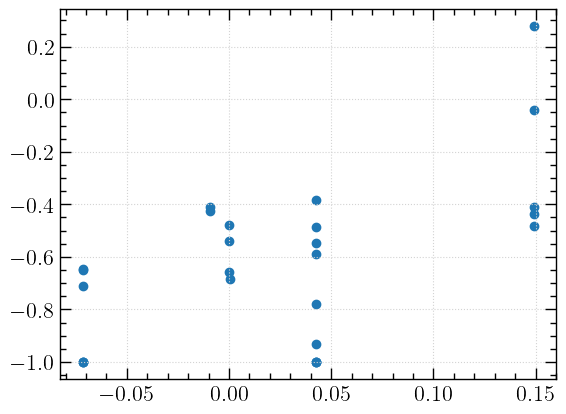

In [40]:
plt.scatter(cluster_members['iso_feh'],cluster_members['best_fit_fe_h'])